In [1]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import yfinance as yf
import numpy as np
import math
import panel as pn
pn.extension('plotly')
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages, the bollinger bands and the keltner channels
#ultimately these will be needed for the squeeze and other calculations
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [3]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period=period, interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

Enter Stock Symbol: SPY
enter period of data eg 1y or 2y: 2y


{'longBusinessSummary': 'The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.', 'maxAge': 86400, 'priceHint': 2, 'previousClose': 442.71, 'open': 444.01, 'dayLow': 443.16, 'dayHigh': 444.4301, 'regularMarketPreviousClose': 442.71, 'regularMarketOpen': 444.01, 'regularMarketDayLow': 443.16, 'regularMarketDayHigh': 444.4301, 'trailingPE': 22.342592, 'volume': 14973562, 'regularMarketVolume': 14973562, 'averageVolume': 72783358, 'averageVolume10days': 70814150, 'averageDailyVolume10Day': 70814150, 'bid': 443.48, 'ask': 443.49, 'bidSize': 1800, 'askSize': 1300, 'yield': 0.0145000005, 'totalAssets': 412799303680, 'fiftyTwoWeekLow': 348.11, 'fiftyTwoWeekHigh': 459.44, 'fiftyDayAverage': 447.5084, 'twoHundredDayAverage': 417.6764, 'trailingAnnualDividendRate': 5.662, 'trailingAnnualDivi

Open        High         Low       Close  \
Date                                                                        
2021-09-20 00:00:00-04:00  421.758040  423.387341  415.919667  420.943390   
2021-09-21 00:00:00-04:00  423.358297  424.696662  420.002706  420.545807   
2021-09-22 00:00:00-04:00  422.892719  426.752638  420.662130  424.648102   
2021-09-23 00:00:00-04:00  426.578109  431.466041  426.335652  429.807617   
2021-09-24 00:00:00-04:00  428.120122  431.252672  427.897052  430.515594   
...                               ...         ...         ...         ...   
2023-09-14 00:00:00-04:00  447.491564  449.494479  446.146303  448.777008   
2023-09-15 00:00:00-04:00  447.140015  447.480011  442.920013  443.369995   
2023-09-18 00:00:00-04:00  443.049988  444.970001  442.559998  443.630005   
2023-09-19 00:00:00-04:00  442.679993  443.290009  439.940002  442.709991   
2023-09-20 00:00:00-04:00  444.010010  444.430115  443.160004  443.529999   

                              Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                          
2021-09-20 00:00:00-04:00  166445500      0.000           0.0            0.0  
2021-09-21 00:00:00-04:00   92526100      0.000           0.0            0.0  
2021-09-22 00:00:00-04:00  102350100      0.000           0.0            0.0  
2021-09-23 00:00:00-04:00   76396000      0.000           0.0            0.0  
2021-09-24 00:00:00-04:00   62094800      0.000           0.0            0.0  
...                              ...        ...           ...            ...  
2023-09-14 00:00:00-04:00   83430800      0.000           0.0            0.0  
2023-09-15 00:00:00-04:00  111761400      1.583           0.0            0.0  
2023-09-18 00:00:00-04:00   55752200      0.000           0.0            0.0  
2023-09-19 00:00:00-04:00   66478700      0.000           0.0            0.0  
2023-09-20 00:00:00-04:00   14974767      0.000           0.0            0.0  

[504 rows x 8 columns]

In [4]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [5]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [6]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [7]:
#ADX Calculations
# Average directional index which shows the trend of the stock.  Above 20 means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

In [8]:
# check for 'squeeze' see if the squeeze is on or off.
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [9]:
# Momentum
# This is the code to eventually make the histograms momentum indicator in the squeeze.  This is where the df['value'] number comes in.

highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock["pct_change"] = df_stock['Close'].pct_change()*100

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.tail()

Open        High         Low       Close  \
Date                                                                        
2023-09-14 00:00:00-04:00  447.491564  449.494479  446.146303  448.777008   
2023-09-15 00:00:00-04:00  447.140015  447.480011  442.920013  443.369995   
2023-09-18 00:00:00-04:00  443.049988  444.970001  442.559998  443.630005   
2023-09-19 00:00:00-04:00  442.679993  443.290009  439.940002  442.709991   
2023-09-20 00:00:00-04:00  444.010010  444.430115  443.160004  443.529999   

                              Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                           
2023-09-14 00:00:00-04:00   83430800      0.000           0.0            0.0   
2023-09-15 00:00:00-04:00  111761400      1.583           0.0            0.0   
2023-09-18 00:00:00-04:00   55752200      0.000           0.0            0.0   
2023-09-19 00:00:00-04:00   66478700      0.000           0.0            0.0   
2023-09-20 00:00:00-04:00   14974767      0.000           0.0            0.0   

                           Moving average    upper_BB    lower_BB    m_avg_08  \
Date                                                                            
2023-09-14 00:00:00-04:00      444.895940  455.197892  434.593988  445.892571   
2023-09-15 00:00:00-04:00      444.750612  454.288756  435.212467  445.331999   
2023-09-18 00:00:00-04:00      444.643887  453.304896  435.982878  444.953778   
2023-09-19 00:00:00-04:00      444.459707  452.659261  436.260152  444.455159   
2023-09-20 00:00:00-04:00      444.371163  451.779376  436.962950  444.249568   

                             m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                        
2023-09-14 00:00:00-04:00  444.850274  444.052170  441.369449  435.509510   
2023-09-15 00:00:00-04:00  444.715703  444.013188  441.440897  435.684190   
2023-09-18 00:00:00-04:00  444.617004  443.991292  441.519080  435.860766   
2023-09-19 00:00:00-04:00  444.443639  443.918075  441.561612  436.012973   
2023-09-20 00:00:00-04:00  444.360581  443.895899  441.631912  436.180020   

                                tr0       tr1       tr2        tr    upper_KC  \
Date                                                                            
2023-09-14 00:00:00-04:00  3.348175  4.553927  1.205751  4.553927  452.844903   
2023-09-15 00:00:00-04:00  4.559998  1.296997  5.856995  5.856995  453.041850   
2023-09-18 00:00:00-04:00  2.410004  1.600006  0.809998  2.410004  452.619559   
2023-09-19 00:00:00-04:00  3.350006  0.339996  3.690002  3.690002  452.381227   
2023-09-20 00:00:00-04:00  1.270111  1.720123  0.450012  1.720123  451.885295   

                             lower_KC       atr    plus_di   minus_di  \
Date                                                                    
2023-09-14 00:00:00-04:00  436.946977  3.791449  31.053057  23.800421   
2023-09-15 00:00:00-04:00  436.459373  4.066855  26.882287  26.270282   
2023-09-18 00:00:00-04:00  436.668215  3.845942  26.395965  26.463670   
2023-09-19 00:00:00-04:00  436.538186  3.825150  24.643768  29.599401   
2023-09-20 00:00:00-04:00  436.857031  3.544480  26.993082  29.661575   

                                 adx  squeeze_on  squeeze_off     value  \
Date                                                                      
2023-09-14 00:00:00-04:00  12.954047         0.0          1.0  6.545017   
2023-09-15 00:00:00-04:00  12.911591         0.0          1.0  5.895020   
2023-09-18 00:00:00-04:00  12.066357         0.0          1.0  5.007469   
2023-09-19 00:00:00-04:00  11.259582         0.0          1.0  3.870898   
2023-09-20 00:00:00-04:00  11.085314         1.0          0.0  3.075988   

                           pct_change  profitable?  
Date                                                
2023-09-14 00:00:00-04:00    0.862240            1  
2023-09-15 00:00:00-04:00   -1.204833            0  
2023-0

In [10]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [11]:
# add colors for the 'value bar'.  See the comment below for what the colors mean.
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [12]:
#This column of colors is added to the dataframe because it will be used as part of our algorithmic trade entry signals
#Red histogram is mark down, Blue is distribution, Yellow is accumulation, and Cyan is mark up
#Generally we want to enter on a squeeze where there is a yellow or cyan histogram
df_stock['colors'] = colors

In [13]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
# The threshold is to set the histogram of the squeeze as close to the zero line as possible
# We want the squeeze to be on and the histogram to be close to zero and the color of the histogram to be yellow or cyan indicating accumulation
# or markup
t_percent = float(input("enter threshold percentage"))
df_stock['value_threshold'] = abs(df_stock['value'].min()* t_percent)
df_stock['squeeze_threshold'] = 1.0
df_stock["squeeze_entry"] = np.logical_and(np.greater(df_stock["value"], df_stock['value_threshold']), 
                                           np.equal(df_stock['squeeze_on'], df_stock['squeeze_threshold']))
df_stock['squeeze_entry'] = df_stock['squeeze_entry'].astype(float)
df_stock['Entry/Exit'] = df_stock['squeeze_entry'].diff()
df_stock_clean = df_stock.dropna()


enter threshold percentage 0.1


In [14]:
#This is the algo strategy.  The entry is when the squeeze is on and the histogram is near 0 and either yellow or cyan as stated before
#Exit strategy is when the stock moves up any percent you want to input
#The form of input is 1.something
#this means for example 1.5 means 50%

percent = float(input("Enter percent return"))
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter percent return 1.10


In [15]:
# calling the algo function and returning the buy price, sell price, and the squeeze signal
buy_price, sell_price, squeeze_signal = implement_bb_strategy(df_stock["Close"], df_stock['squeeze_on'], df_stock['value'], 
                                                              df_stock['upper_KC'], df_stock['value_threshold'], df_stock['colors'], percent)

In [16]:
#setting dataframes to the results of the algo function
df_stock['buy_price'] =  buy_price
df_stock['sell_price'] = sell_price
df_stock['squeeze_signal'] = squeeze_signal

In [17]:
# This is give the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [18]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(squeeze_signal)):
    if df_stock['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock['Close']
squeeze_signal = pd.DataFrame(squeeze_signal).rename(columns = {0:'squeeze_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock.index)

frames = [close_price, squeeze_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy.tail()

Date       Close  squeeze_signal  squeeze_position
459 2023-09-14 00:00:00-04:00  448.777008             0.0                 1
460 2023-09-15 00:00:00-04:00  443.369995             0.0                 1
461 2023-09-18 00:00:00-04:00  443.630005             0.0                 1
462 2023-09-19 00:00:00-04:00  442.709991             0.0                 1
463 2023-09-20 00:00:00-04:00  443.529999             0.0                 1

In [19]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)


Profit gained from the Squeeze strategy by investing $100k in SPY is -2774.88
Profit percentage of the Squeeze strategy : -3%
-2774.8778076171875


In [20]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'squeeze_on', 'upper_KC', 'lower_KC', 'squeeze_signal']

# Filter by x-variable list
df_stock[x_var_list]

Open        High         Low       Close  \
Date                                                                        
2021-11-15 00:00:00-05:00  454.499439  454.664293  452.162154  453.325928   
2021-11-16 00:00:00-05:00  453.054382  456.293599  452.976809  455.120117   
2021-11-17 00:00:00-05:00  454.848502  455.032771  453.374376  454.014465   
2021-11-18 00:00:00-05:00  455.081314  455.828099  452.268823  455.556549   
2021-11-19 00:00:00-05:00  455.440098  456.729984  454.363605  454.741852   
2021-11-22 00:00:00-05:00  456.681500  459.251534  453.248307  453.461670   
2021-11-23 00:00:00-05:00  453.122195  454.945473  450.435787  454.062927   
2021-11-24 00:00:00-05:00  451.997221  455.401320  451.153476  455.275238   
2021-11-26 00:00:00-05:00  448.389495  449.902422  443.957382  445.121185   
2021-11-29 00:00:00-05:00  450.067231  452.482089  447.797841  450.581238   
2021-11-30 00:00:00-05:00  448.059740  450.028486  441.561892  441.814056   
2021-12-01 00:00:00-05:00  447.710648  450.649221  436.703114  436.906769   
2021-12-02 00:00:00-05:00  437.129786  445.218134  436.722446  443.598511   
2021-12-03 00:00:00-05:00  445.315118  446.410996  435.374399  439.738617   
2021-12-06 00:00:00-05:00  442.366823  446.886216  439.874362  444.946564   
2021-12-07 00:00:00-05:00  450.397076  454.732201  444.810866  454.150299   
2021-12-08 00:00:00-05:00  454.557579  455.818341  452.743979  455.352814   
2021-12-09 00:00:00-05:00  454.024179  455.459533  452.074848  452.278503   
2021-12-10 00:00:00-05:00  455.071532  456.691125  452.433604  456.535950   
2021-12-13 00:00:00-05:00  456.002649  456.361480  452.200917  452.491882   
2021-12-14 00:00:00-05:00  449.116881  451.686915  446.362577  449.378723   
2021-12-15 00:00:00-05:00  449.436923  456.652403  446.837766  456.400269   
2021-12-16 00:00:00-05:00  458.310820  458.601757  450.775251  452.375488   
2021-12-17 00:00:00-05:00  449.195938  452.300556  445.799363  447.560913   
2021-12-20 00:00:00-05:00  442.315172  443.210530  439.064575  442.801788   
2021-12-21 00:00:00-05:00  446.334656  450.811537  444.096231  450.665558   
2021-12-22 00:00:00-05:00  450.402762  455.288384  450.198361  455.171600   
2021-12-23 00:00:00-05:00  456.203235  459.551161  456.096194  458.003723   
2021-12-27 00:00:00-05:00  459.424617  464.534093  459.375967  464.485443   
2021-12-28 00:00:00-05:00  464.933120  465.993941  463.317549  464.105865   
2021-12-29 00:00:00-05:00  464.212938  465.750634  463.181313  464.699554   
2021-12-30 00:00:00-05:00  465.137469  466.178835  462.937981  463.414856   
2021-12-31 00:00:00-05:00  462.908831  464.096147  461.964793  462.247009   
2022-01-03 00:00:00-05:00  463.551168  465.059698  461.166764  464.923431   
2022-01-04 00:00:00-05:00  466.392952  467.132619  462.850368  464.767639   
2022-01-05 00:00:00-05:00  464.388098  465.186157  455.745780  455.843109   
2022-01-06 00:00:00-05:00  455.366267  458.217834  452.972091  455.414917   
2022-01-07 00:00:00-05:00  455.424671  456.641213  452.212982  453.614441   
2022-01-10 00:00:00-05:00  450.315173  453.273782  444.378443  453.049957   
2022-01-11 00:00:00-05:00  452.777418  457.273751  449.682513  457.176422   
2022-01-12 00:00:00-05:00  458.967165  460.534086  456.388102  458.412415   
2022-01-13 00:00:00-05:00  459.551133  460.222667  451.035340  452.096161   
2022-01-14 00:00:00-05:00  448.845584  452.641189  447.590105  452.281097   
2022-01-18 00:00:00-05:00  447.434341  447.648453  443.122923  444.271332   
2022-01-19 00:00:00-05:00  445.867499  447.307866  439.376018  439.658264   
2022-01-20 00:00:00-05:00  441.604688  446.461113  432.602278  434.792053   
2022-01-21 00:00:00-05:00  433.633933  436.067017  426.227640  426.256836   
2022-01-24 00:00:00-05:00  420.466065  428.592571  409.497735  428.067017   
2022-01-25 00:00:00-05:00  421.468496  427.950235  415.716683  422.840759   
2022-01-26 00:00:00-05:00  428.923468  432.154610  417.380903  421.779938   
2022-01-27 00:00:00-05:00  42

In [21]:
# Shift DataFrame values by 1
df_stock[x_var_list] = df_stock[x_var_list].shift(1)
df_stock[x_var_list].tail()

Open        High         Low       Close  \
Date                                                                        
2023-09-14 00:00:00-04:00  444.651563  446.136316  443.515555  444.940552   
2023-09-15 00:00:00-04:00  447.491564  449.494479  446.146303  448.777008   
2023-09-18 00:00:00-04:00  447.140015  447.480011  442.920013  443.369995   
2023-09-19 00:00:00-04:00  443.049988  444.970001  442.559998  443.630005   
2023-09-20 00:00:00-04:00  442.679993  443.290009  439.940002  442.709991   

                           Moving average    upper_BB    lower_BB    m_avg_08  \
Date                                                                            
2023-09-14 00:00:00-04:00      444.487406  454.640580  434.334232  445.068446   
2023-09-15 00:00:00-04:00      444.895940  455.197892  434.593988  445.892571   
2023-09-18 00:00:00-04:00      444.750612  454.288756  435.212467  445.331999   
2023-09-19 00:00:00-04:00      444.643887  453.304896  435.982878  444.953778   
2023-09-20 00:00:00-04:00      444.459707  452.659261  436.260152  444.455159   

                           pct_change  squeeze_on    upper_KC    lower_KC  \
Date                                                                        
2023-09-14 00:00:00-04:00    0.116598         0.0  452.320480  436.654332   
2023-09-15 00:00:00-04:00    0.862240         0.0  452.844903  436.946977   
2023-09-18 00:00:00-04:00   -1.204833         0.0  453.041850  436.459373   
2023-09-19 00:00:00-04:00    0.058644         0.0  452.619559  436.668215   
2023-09-20 00:00:00-04:00   -0.207383         0.0  452.381227  436.538186   

                           squeeze_signal  
Date                                       
2023-09-14 00:00:00-04:00             0.0  
2023-09-15 00:00:00-04:00             0.0  
2023-09-18 00:00:00-04:00             0.0  
2023-09-19 00:00:00-04:00             0.0  
2023-09-20 00:00:00-04:00             0.0

In [22]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)

# Display sample data
df_stock.head()

Open        High         Low       Close  \
Date                                                                        
2021-11-16 00:00:00-05:00  454.499439  454.664293  452.162154  453.325928   
2021-11-17 00:00:00-05:00  453.054382  456.293599  452.976809  455.120117   
2021-11-18 00:00:00-05:00  454.848502  455.032771  453.374376  454.014465   
2021-11-19 00:00:00-05:00  455.081314  455.828099  452.268823  455.556549   
2021-11-22 00:00:00-05:00  455.440098  456.729984  454.363605  454.741852   

                             Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                          
2021-11-16 00:00:00-05:00  48857500        0.0           0.0            0.0   
2021-11-17 00:00:00-05:00  47858300        0.0           0.0            0.0   
2021-11-18 00:00:00-05:00  50625600        0.0           0.0            0.0   
2021-11-19 00:00:00-05:00  57315600        0.0           0.0            0.0   
2021-11-22 00:00:00-05:00  72762000        0.0           0.0            0.0   

                           Moving average    upper_BB    lower_BB    m_avg_08  \
Date                                                                            
2021-11-16 00:00:00-05:00      446.540949  458.456623  434.625274  451.442752   
2021-11-17 00:00:00-05:00      447.370407  458.917984  435.822830  452.259965   
2021-11-18 00:00:00-05:00      448.011847  459.087378  436.936315  452.649862   
2021-11-19 00:00:00-05:00      448.739288  459.484997  437.993579  453.295803   
2021-11-22 00:00:00-05:00      449.317358  459.285556  439.349161  453.617151   

                             m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                        
2021-11-16 00:00:00-05:00  447.007396  443.489671  440.676996  438.754841   
2021-11-17 00:00:00-05:00  447.655155  444.143134  441.279450  439.302201   
2021-11-18 00:00:00-05:00  448.384470  444.848284  441.918307  439.877391   
2021-11-19 00:00:00-05:00  448.970453  445.456710  442.486985  440.396563   
2021-11-22 00:00:00-05:00  449.383902  445.946858  442.969507  440.847164   

                                tr0       tr1       tr2        tr    upper_KC  \
Date                                                                            
2021-11-16 00:00:00-05:00  3.316790  2.967671  0.349119  3.316790  453.393736   
2021-11-17 00:00:00-05:00  1.658395  0.087346  1.745741  1.745741  454.202895   
2021-11-18 00:00:00-05:00  3.559276  1.813634  1.745642  3.559276  454.535480   
2021-11-19 00:00:00-05:00  2.366378  1.173435  1.192944  2.366378  455.317834   
2021-11-22 00:00:00-05:00  6.003227  4.509682  1.493545  6.003227  455.725771   

                             lower_KC       atr    plus_di   minus_di  \
Date                                                                    
2021-11-16 00:00:00-05:00  439.688161  3.255842  40.950174  17.590301   
2021-11-17 00:00:00-05:00  440.537918  3.054066  40.392221  17.350630   
2021-11-18 00:00:00-05:00  441.488213  3.121551  38.472874  18.349515   
2021-11-19 00:00:00-05:00  442.160742  3.020701  39.021959  17.553675   
2021-11-22 00:00:00-05:00  442.908946  3.418922  37.385891  16.776548   

                                 adx  squeeze_on  squeeze_off      value  \
Date                                                                       
2021-11-16 00:00:00-05:00  38.019228         0.0          1.0  10.380123   
2021-11-17 00:00:00-05:00  38.160614         0.0          1.0   9.448295   
2021-11-18 00:00:00-05:00  38.266954         0.0          1.0   8.838885   
2021-11-19 00:00:00-05:00  38.067900         0.0          1.0   8.096565   
2021-11-22 00:00:00-05:00  38.059414         0.0          1.0   6.878636   

                           pct_change  profitable? colors  value_threshold  \
Date                                                                         
2021-11-16 00:00:00-05:00    0.034244            1   blue     

In [23]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

Open        High         Low       Close  \
Date                                                                        
2021-11-16 00:00:00-05:00  454.499439  454.664293  452.162154  453.325928   
2021-11-17 00:00:00-05:00  453.054382  456.293599  452.976809  455.120117   
2021-11-18 00:00:00-05:00  454.848502  455.032771  453.374376  454.014465   
2021-11-19 00:00:00-05:00  455.081314  455.828099  452.268823  455.556549   
2021-11-22 00:00:00-05:00  455.440098  456.729984  454.363605  454.741852   
2021-11-23 00:00:00-05:00  456.681500  459.251534  453.248307  453.461670   
2021-11-24 00:00:00-05:00  453.122195  454.945473  450.435787  454.062927   
2021-11-26 00:00:00-05:00  451.997221  455.401320  451.153476  455.275238   
2021-11-29 00:00:00-05:00  448.389495  449.902422  443.957382  445.121185   
2021-11-30 00:00:00-05:00  450.067231  452.482089  447.797841  450.581238   
2021-12-01 00:00:00-05:00  448.059740  450.028486  441.561892  441.814056   
2021-12-02 00:00:00-05:00  447.710648  450.649221  436.703114  436.906769   
2021-12-03 00:00:00-05:00  437.129786  445.218134  436.722446  443.598511   
2021-12-06 00:00:00-05:00  445.315118  446.410996  435.374399  439.738617   
2021-12-07 00:00:00-05:00  442.366823  446.886216  439.874362  444.946564   
2021-12-08 00:00:00-05:00  450.397076  454.732201  444.810866  454.150299   
2021-12-09 00:00:00-05:00  454.557579  455.818341  452.743979  455.352814   
2021-12-10 00:00:00-05:00  454.024179  455.459533  452.074848  452.278503   
2021-12-13 00:00:00-05:00  455.071532  456.691125  452.433604  456.535950   
2021-12-14 00:00:00-05:00  456.002649  456.361480  452.200917  452.491882   
2021-12-15 00:00:00-05:00  449.116881  451.686915  446.362577  449.378723   
2021-12-16 00:00:00-05:00  449.436923  456.652403  446.837766  456.400269   
2021-12-17 00:00:00-05:00  458.310820  458.601757  450.775251  452.375488   
2021-12-20 00:00:00-05:00  449.195938  452.300556  445.799363  447.560913   
2021-12-21 00:00:00-05:00  442.315172  443.210530  439.064575  442.801788   
2021-12-22 00:00:00-05:00  446.334656  450.811537  444.096231  450.665558   
2021-12-23 00:00:00-05:00  450.402762  455.288384  450.198361  455.171600   
2021-12-27 00:00:00-05:00  456.203235  459.551161  456.096194  458.003723   
2021-12-28 00:00:00-05:00  459.424617  464.534093  459.375967  464.485443   
2021-12-29 00:00:00-05:00  464.933120  465.993941  463.317549  464.105865   
2021-12-30 00:00:00-05:00  464.212938  465.750634  463.181313  464.699554   
2021-12-31 00:00:00-05:00  465.137469  466.178835  462.937981  463.414856   
2022-01-03 00:00:00-05:00  462.908831  464.096147  461.964793  462.247009   
2022-01-04 00:00:00-05:00  463.551168  465.059698  461.166764  464.923431   
2022-01-05 00:00:00-05:00  466.392952  467.132619  462.850368  464.767639   
2022-01-06 00:00:00-05:00  464.388098  465.186157  455.745780  455.843109   
2022-01-07 00:00:00-05:00  455.366267  458.217834  452.972091  455.414917   
2022-01-10 00:00:00-05:00  455.424671  456.641213  452.212982  453.614441   
2022-01-11 00:00:00-05:00  450.315173  453.273782  444.378443  453.049957   
2022-01-12 00:00:00-05:00  452.777418  457.273751  449.682513  457.176422   
2022-01-13 00:00:00-05:00  458.967165  460.534086  456.388102  458.412415   
2022-01-14 00:00:00-05:00  459.551133  460.222667  451.035340  452.096161   
2022-01-18 00:00:00-05:00  448.845584  452.641189  447.590105  452.281097   
2022-01-19 00:00:00-05:00  447.434341  447.648453  443.122923  444.271332   
2022-01-20 00:00:00-05:00  445.867499  447.307866  439.376018  439.658264   
2022-01-21 00:00:00-05:00  441.604688  446.461113  432.602278  434.792053   
2022-01-24 00:00:00-05:00  433.633933  436.067017  426.227640  426.256836   
2022-01-25 00:00:00-05:00  420.466065  428.592571  409.497735  428.067017   
2022-01-26 00:00:00-05:00  421.468496  427.950235  415.716683  422.840759   
2022-01-27 00:00:00-05:00  428.923468  432.154610  417.380903  421.779938   
2022-01-28 00:00:00-05:00  42

In [26]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2022-03-20"

# Construct testing start and end dates
testing_start =  "2022-03-21"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-11-16
Training End: 2022-03-20
Testing Start: 2022-03-21
Testing End: 2023-09-20


In [27]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Open        High         Low       Close  \
Date                                                                        
2022-03-14 00:00:00-04:00  416.660751  417.293347  408.300678  408.826233   
2022-03-15 00:00:00-04:00  409.624241  413.186249  404.660744  405.838348   
2022-03-16 00:00:00-04:00  408.534221  415.414989  407.220380  414.762939   
2022-03-17 00:00:00-04:00  418.383382  424.018383  413.429597  423.959991   
2022-03-18 00:00:00-04:00  421.984362  429.264160  421.595074  429.264160   

                           Moving average    upper_BB    lower_BB    m_avg_08  \
Date                                                                            
2022-03-14 00:00:00-04:00      420.308211  437.033387  403.583035  414.226132   
2022-03-15 00:00:00-04:00      418.930122  436.417336  401.442907  412.362180   
2022-03-16 00:00:00-04:00      418.533245  435.726957  401.339534  412.895682   
2022-03-17 00:00:00-04:00      419.050081  434.872226  403.227935  415.354417   
2022-03-18 00:00:00-04:00      420.022854  434.821562  405.224145  418.445471   

                           pct_change  squeeze_on    upper_KC    lower_KC  \
Date                                                                        
2022-03-14 00:00:00-04:00   -1.271506         1.0  439.404283  401.212139   
2022-03-15 00:00:00-04:00   -0.730845         1.0  437.840277  400.019966   
2022-03-16 00:00:00-04:00    2.199051         1.0  437.465504  399.600987   
2022-03-17 00:00:00-04:00    2.217424         1.0  438.186460  399.913701   
2022-03-18 00:00:00-04:00    1.251101         1.0  438.813939  401.231768   

                           squeeze_signal  
Date                                       
2022-03-14 00:00:00-04:00             0.0  
2022-03-15 00:00:00-04:00             0.0  
2022-03-16 00:00:00-04:00             0.0  
2022-03-17 00:00:00-04:00             0.0  
2022-03-18 00:00:00-04:00             0.0

Date
2022-03-14 00:00:00-04:00    0.0
2022-03-15 00:00:00-04:00    0.0
2022-03-16 00:00:00-04:00    1.0
2022-03-17 00:00:00-04:00    1.0
2022-03-18 00:00:00-04:00    1.0
Name: Positive Return, dtype: float64

In [28]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Open        High         Low       Close  \
Date                                                                        
2023-09-14 00:00:00-04:00  444.651563  446.136316  443.515555  444.940552   
2023-09-15 00:00:00-04:00  447.491564  449.494479  446.146303  448.777008   
2023-09-18 00:00:00-04:00  447.140015  447.480011  442.920013  443.369995   
2023-09-19 00:00:00-04:00  443.049988  444.970001  442.559998  443.630005   
2023-09-20 00:00:00-04:00  442.679993  443.290009  439.940002  442.709991   

                           Moving average    upper_BB    lower_BB    m_avg_08  \
Date                                                                            
2023-09-14 00:00:00-04:00      444.487406  454.640580  434.334232  445.068446   
2023-09-15 00:00:00-04:00      444.895940  455.197892  434.593988  445.892571   
2023-09-18 00:00:00-04:00      444.750612  454.288756  435.212467  445.331999   
2023-09-19 00:00:00-04:00      444.643887  453.304896  435.982878  444.953778   
2023-09-20 00:00:00-04:00      444.459707  452.659261  436.260152  444.455159   

                           pct_change  squeeze_on    upper_KC    lower_KC  \
Date                                                                        
2023-09-14 00:00:00-04:00    0.116598         0.0  452.320480  436.654332   
2023-09-15 00:00:00-04:00    0.862240         0.0  452.844903  436.946977   
2023-09-18 00:00:00-04:00   -1.204833         0.0  453.041850  436.459373   
2023-09-19 00:00:00-04:00    0.058644         0.0  452.619559  436.668215   
2023-09-20 00:00:00-04:00   -0.207383         0.0  452.381227  436.538186   

                           squeeze_signal  
Date                                       
2023-09-14 00:00:00-04:00             0.0  
2023-09-15 00:00:00-04:00             0.0  
2023-09-18 00:00:00-04:00             0.0  
2023-09-19 00:00:00-04:00             0.0  
2023-09-20 00:00:00-04:00             0.0

Date
2023-09-14 00:00:00-04:00    1.0
2023-09-15 00:00:00-04:00    1.0
2023-09-18 00:00:00-04:00    0.0
2023-09-19 00:00:00-04:00    1.0
2023-09-20 00:00:00-04:00    0.0
Name: Positive Return, dtype: float64

In [29]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [30]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results.tail()

Positive Return  Predicted Value
Date                                                       
2023-09-14 00:00:00-04:00              1.0              1.0
2023-09-15 00:00:00-04:00              1.0              1.0
2023-09-18 00:00:00-04:00              0.0              0.0
2023-09-19 00:00:00-04:00              1.0              1.0
2023-09-20 00:00:00-04:00              0.0              0.0

In [31]:
# Save the pre-trained model
from joblib import dump, load
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [32]:
results.head()

Positive Return  Predicted Value
Date                                                       
2022-03-21 00:00:00-04:00              1.0              1.0
2022-03-22 00:00:00-04:00              0.0              0.0
2022-03-23 00:00:00-04:00              1.0              1.0
2022-03-24 00:00:00-04:00              0.0              0.0
2022-03-25 00:00:00-04:00              1.0              1.0

In [33]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([1., 0., 1., 0., 1., 1., 1., 1., 0., 0.])

In [34]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sample data
results.tail(10)

Positive Return  Predicted Value
Date                                                       
2023-09-07 00:00:00-04:00              0.0              0.0
2023-09-08 00:00:00-04:00              0.0              0.0
2023-09-11 00:00:00-04:00              1.0              1.0
2023-09-12 00:00:00-04:00              1.0              1.0
2023-09-13 00:00:00-04:00              0.0              0.0
2023-09-14 00:00:00-04:00              1.0              1.0
2023-09-15 00:00:00-04:00              1.0              1.0
2023-09-18 00:00:00-04:00              0.0              0.0
2023-09-19 00:00:00-04:00              1.0              1.0
2023-09-20 00:00:00-04:00              0.0              0.0

<Axes: xlabel='Date'>

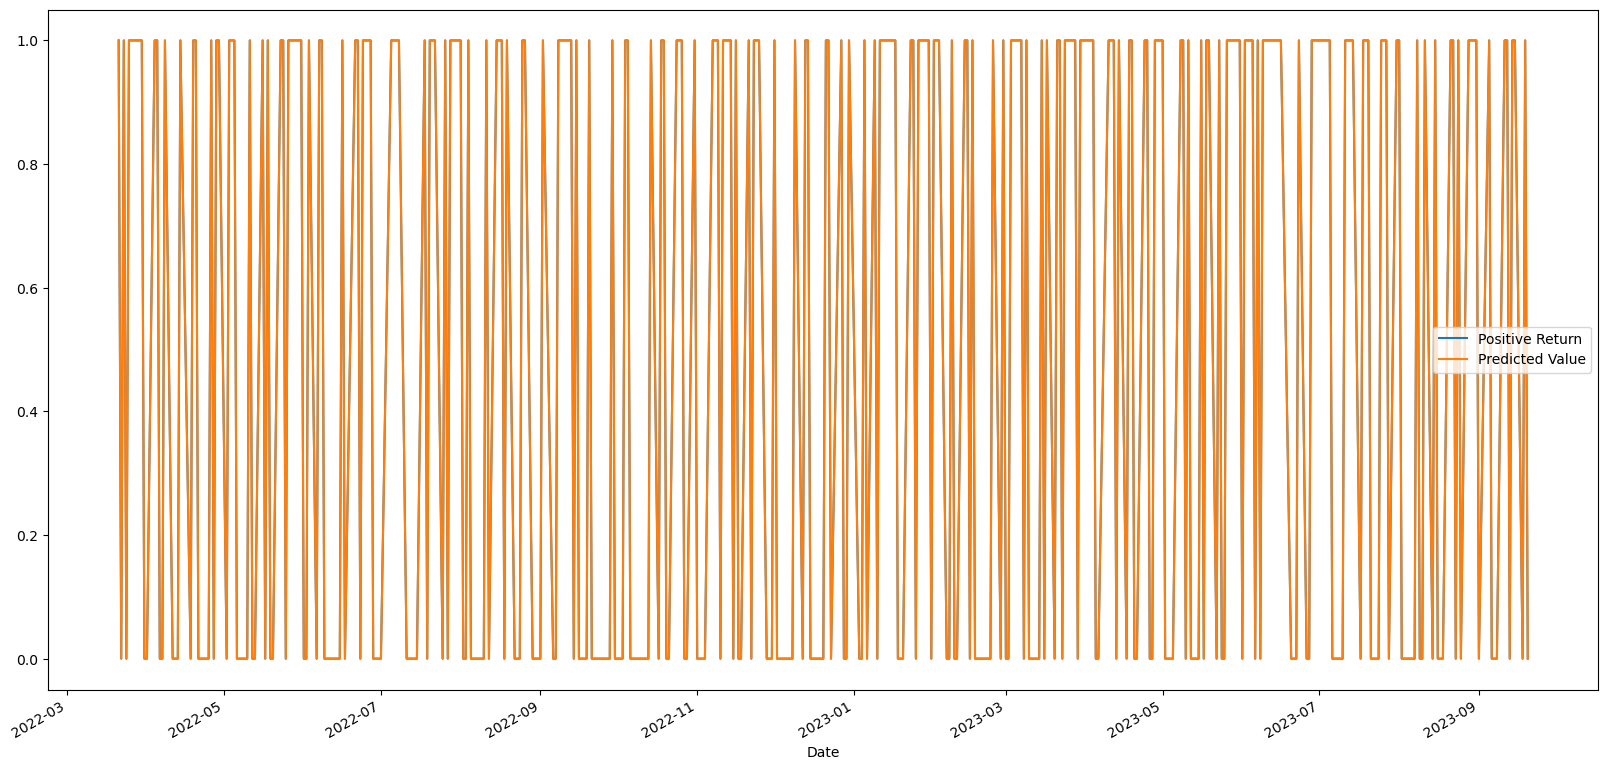

In [35]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))

<Axes: xlabel='Date'>

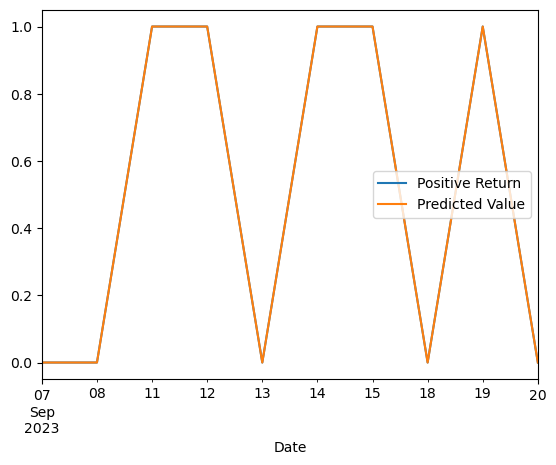

In [36]:
# Plot last 10 records of predicted vs. actual results
results[["Positive Return", "Predicted Value"]].tail(10).plot()

In [37]:
results['Return'] = df_stock['pct_change']
results

Positive Return  Predicted Value    Return
Date                                                                 
2022-03-21 00:00:00-04:00              1.0              1.0  1.095269
2022-03-22 00:00:00-04:00              0.0              0.0 -0.029247
2022-03-23 00:00:00-04:00              1.0              1.0  1.170144
2022-03-24 00:00:00-04:00              0.0              0.0 -1.287840
2022-03-25 00:00:00-04:00              1.0              1.0  1.507436
2022-03-28 00:00:00-04:00              1.0              1.0  0.488364
2022-03-29 00:00:00-04:00              1.0              1.0  0.711298
2022-03-30 00:00:00-04:00              1.0              1.0  1.237076
2022-03-31 00:00:00-04:00              0.0              0.0 -0.617475
2022-04-01 00:00:00-04:00              0.0              0.0 -1.539130
2022-04-04 00:00:00-04:00              1.0              1.0  0.283410
2022-04-05 00:00:00-04:00              1.0              1.0  0.856662
2022-04-06 00:00:00-04:00              0.0              0.0 -1.263140
2022-04-07 00:00:00-04:00              0.0              0.0 -0.999935
2022-04-08 00:00:00-04:00              1.0              1.0  0.503901
2022-04-11 00:00:00-04:00              0.0              0.0 -0.267398
2022-04-12 00:00:00-04:00              0.0              0.0 -1.709227
2022-04-13 00:00:00-04:00              0.0              0.0 -0.370517
2022-04-14 00:00:00-04:00              1.0              1.0  1.145362
2022-04-18 00:00:00-04:00              0.0              0.0 -1.245187
2022-04-19 00:00:00-04:00              1.0              1.0  0.041114
2022-04-20 00:00:00-04:00              1.0              1.0  1.614271
2022-04-21 00:00:00-04:00              0.0              0.0 -0.074160
2022-04-22 00:00:00-04:00              0.0              0.0 -1.495347
2022-04-25 00:00:00-04:00              0.0              0.0 -2.743919
2022-04-26 00:00:00-04:00              1.0              1.0  0.579770
2022-04-27 00:00:00-04:00              0.0              0.0 -2.896083
2022-04-28 00:00:00-04:00              1.0              1.0  0.281165
2022-04-29 00:00:00-04:00              1.0              1.0  2.525946
2022-05-02 00:00:00-04:00              0.0              0.0 -3.695568
2022-05-03 00:00:00-04:00              1.0              1.0  0.601940
2022-05-04 00:00:00-04:00              1.0              1.0  0.458421
2022-05-05 00:00:00-04:00              1.0              1.0  3.045287
2022-05-06 00:00:00-04:00              0.0              0.0 -3.554286
2022-05-09 00:00:00-04:00              0.0              0.0 -0.596898
2022-05-10 00:00:00-04:00              0.0              0.0 -3.201730
2022-05-11 00:00:00-04:00              1.0              1.0  0.231067
2022-05-12 00:00:00-04:00              0.0              0.0 -1.588618
2022-05-13 00:00:00-04:00              0.0              0.0 -0.104393
2022-05-16 00:00:00-04:00              1.0              1.0  2.390791
2022-05-17 00:00:00-04:00              0.0              0.0 -0.405765
2022-05-18 00:00:00-04:00              1.0              1.0  2.057040
2022-05-19 00:00:00-04:00              0.0              0.0 -4.031150
2022-05-20 00:00:00-04:00              0.0              0.0 -0.612472
2022-05-23 00:00:00-04:00              1.0              1.0  0.043656
2022-05-24 00:00:00-04:00              1.0              1.0  1.871014
2022-05-25 00:00:00-04:00              0.0              0.0 -0.763381
2022-05-26 00:00:00-04:00              1.0              1.0  0.883494
2022-05-27 00:00:00-04:00              1.0              1.0  1.998134
2022-05-31 00:00:00-04:00              1.0              1.0  2.454916
2022-06-01 00:00:00-04:00              0.0              0.0 -0.561097
2022-06-02 00:00:00-04:00              0.0              0.0 -0.808857
2022-06-03 00:00:00-04:00              1.0              1.0  1.904352
2022-06-06 00:00:00-04:00              0.0              0.0 -1.641155
2022-06-07 00:00:00-04:00              1.0              1.0  0.304481
2022-06-08 00:00:00-04:00            

<Axes: xlabel='Date'>

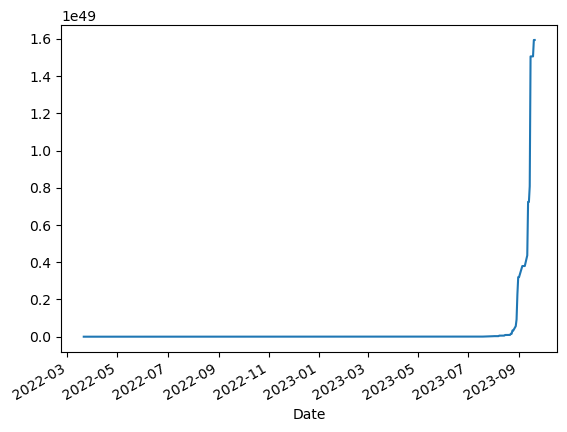

In [38]:
# Calculate cumulative return of the model
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<Axes: xlabel='Date'>

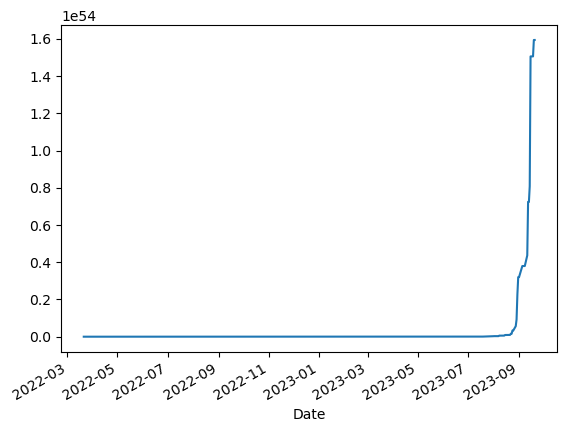

In [39]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [ ]:
period_hr = input("Enter time period, eg 3mo, 6mo, etc:")
stock_df_hr = stock.history(period=period_hr, interval='1h')
stock_df_hr.index.duplicated().sum()
df_stock_hr = stock_df_hr.loc[~stock_df_hr.index.duplicated(keep='first')]
df_stock_hr.tail()